In [14]:
%load_ext autoreload
%autoreload 2

import sys
sys.dont_write_bytecode = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
#imports
import itertools

import pandas as pd
import numpy as np

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score,roc_auc_score,roc_curve,confusion_matrix, accuracy_score
from catboost import CatBoostClassifier

from callables import process_dataset,plot_roc_curve,find_max_fscore,plot_confusion_matrix,plot_feature_importnaces

import warnings
warnings.filterwarnings('ignore')

In [16]:
shift = -9
anomaly_crtiretion = 1.0030

In [17]:
#read
df = pd.read_csv('./data/features.csv', index_col = 0)

In [5]:
#process_dataset
df_event, df_proc = process_dataset(df, shift, anomaly_crtiretion)

In [6]:
#display
display(df_event.head())
display(df_proc.head())

,t_start,open_price,close_price,low_price,high_price,n_trades,base_volume,quote_volume,buy_base,target
0,2022-05-26 16:08:27.217,28869.3,28856.2,28856.2,28874.8,1210,87.607,2.529125e+06,51.826,False
1,2022-05-26 16:08:27.533,28869.3,28856.2,28856.2,28874.8,1221,88.177,2.545573e+06,51.828,False
2,2022-05-26 16:08:27.915,28869.3,28856.2,28856.2,28874.8,1227,88.384,2.551546e+06,51.841,False
3,2022-05-26 16:08:28.165,28869.3,28856.3,28856.2,28874.8,1232,88.496,2.554778e+06,51.844,False
4,2022-05-26 16:08:28.626,28869.3,28856.2,28856.2,28874.8,1236,88.568,2.556856e+06,51.912,False


,t_start,t_end,close_delta,trades_delta,quote_volume_delta,buy_quote_delta,target
0,2022-05-26 16:08:27.217,2022-05-26 16:08:27.533,0.0,11.0,16448.0342,57.7126,False
1,2022-05-26 16:08:27.533,2022-05-26 16:08:27.915,0.0,6.0,5973.2347,375.1319,False
2,2022-05-26 16:08:27.915,2022-05-26 16:08:28.165,0.1,5.0,3231.8947,86.5689,False
3,2022-05-26 16:08:28.165,2022-05-26 16:08:28.626,-0.1,4.0,2077.6532,1962.2284,False
4,2022-05-26 16:08:28.626,2022-05-26 16:08:28.956,0.0,6.0,11196.2056,0.0000,False


### features delta

In [7]:
border_l = 180000
border_r = 190000

scaler = StandardScaler()

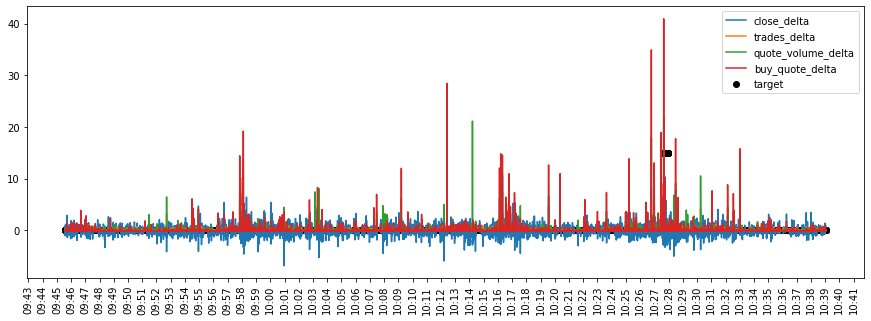

In [8]:
fig, ax = plt.subplots()

ax.plot(df_proc.t_start[border_l:border_r],
        scaler.fit(df_proc.close_delta.values.reshape(-1,1)).
        transform(df_proc.close_delta[border_l:border_r].values.reshape(-1,1)),
        label = 'close_delta')
ax.plot(df_proc.t_start[border_l:border_r],
        scaler.fit(df_proc.trades_delta.values.reshape(-1,1)).
        transform(df_proc.trades_delta[border_l:border_r].values.reshape(-1,1)),
        label = 'trades_delta')
ax.plot(df_proc.t_start[border_l:border_r],
        scaler.fit(df_proc.quote_volume_delta.values.reshape(-1,1)).
        transform(df_proc.quote_volume_delta[border_l:border_r].values.reshape(-1,1)),
        label = 'quote_volume_delta')
ax.plot(df_proc.t_start[border_l:border_r],
        scaler.fit(df_proc.buy_quote_delta.values.reshape(-1,1)).
        transform(df_proc.buy_quote_delta[border_l:border_r].values.reshape(-1,1)),
        label = 'buy_quote_delta')
ax.scatter(df_proc.t_start[border_l:border_r],
           df_proc['target'][border_l:border_r].astype(int)*15,
           label = 'target', color = 'black')

ax.xaxis.set_major_locator(mdates.MinuteLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=90)
ax.legend()
fig.set_size_inches([15,5])

plt.show()

1. Видим появление аномалий каждый раз через минуту после всплесков признаков
2. Кажется что закономерность с buy_quote_delta самая сильная

#### close_delta

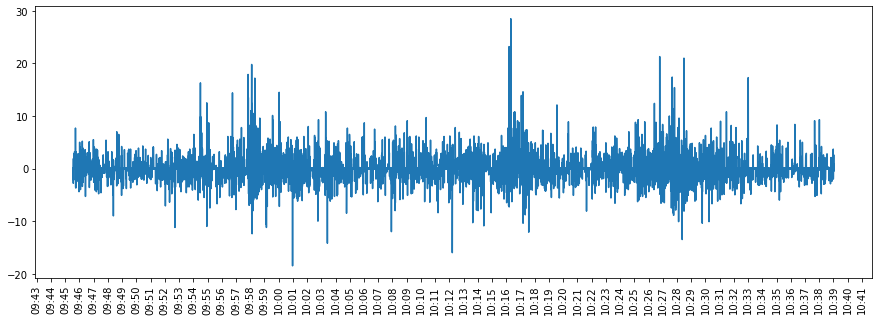

In [9]:
fig, ax = plt.subplots()

ax.plot(df_proc.t_start[border_l:border_r], 
        df_proc.close_delta[border_l:border_r])

ax.xaxis.set_major_locator(mdates.MinuteLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.xticks(rotation=90)

fig.set_size_inches([15,5])

plt.show()

#### n_trades_delta

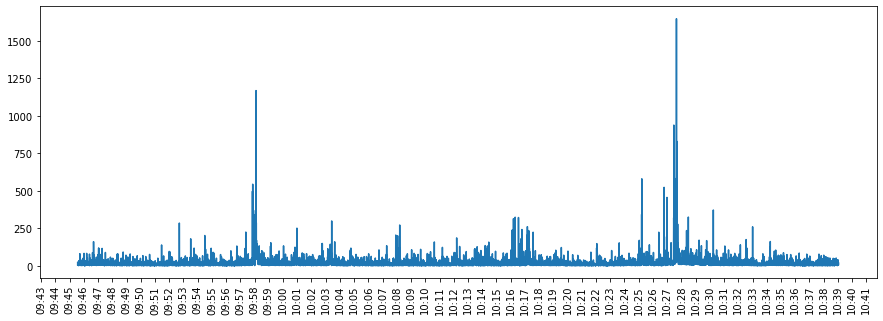

In [10]:
fig, ax = plt.subplots()

ax.plot(df_proc.t_start[border_l:border_r],
        df_proc.trades_delta[border_l:border_r])

ax.xaxis.set_major_locator(mdates.MinuteLocator())
majorFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(majorFmt)

plt.xticks(rotation=90)

fig.set_size_inches([15,5])

plt.show()

#### quote_volume_delta

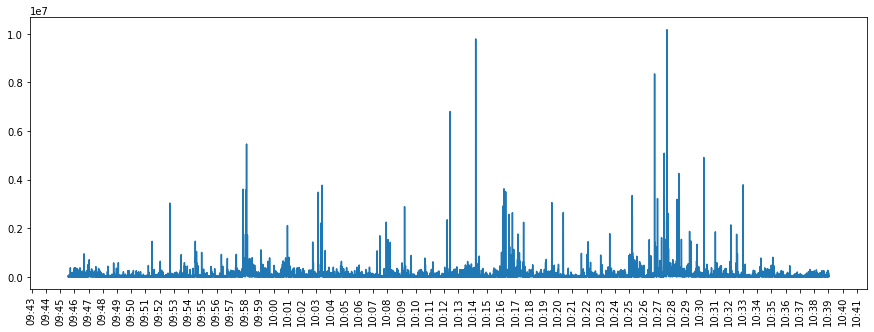

In [11]:
fig, ax = plt.subplots()

ax.plot(df_proc.t_start[border_l:border_r],
        df_proc.quote_volume_delta[border_l:border_r])

ax.xaxis.set_major_locator(mdates.MinuteLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.xticks(rotation=90)

fig.set_size_inches([15,5])

plt.show()

#### buy_quote_delta

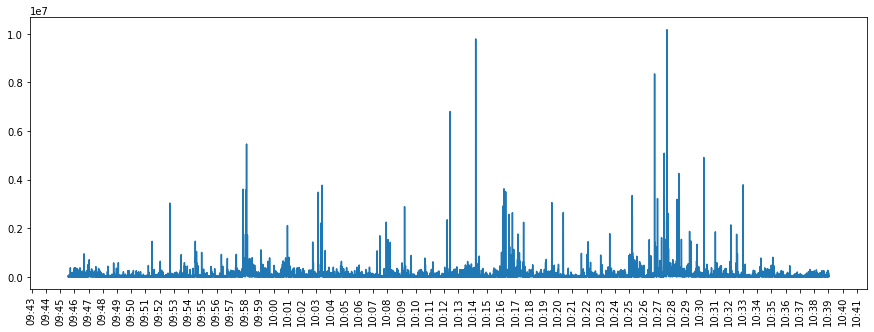

In [12]:
fig, ax = plt.subplots()

ax.plot(df_proc.t_start[border_l:border_r], 
        df_proc.quote_volume_delta[border_l:border_r])

ax.xaxis.set_major_locator(mdates.MinuteLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.xticks(rotation=90)

fig.set_size_inches([15,5])

plt.show()

## target

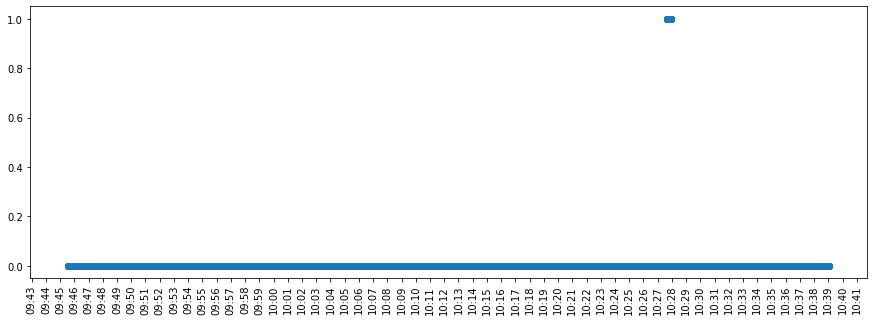

In [13]:
fig, ax = plt.subplots()

ax.scatter(df_proc.t_start[border_l:border_r],
           df_proc['target'][border_l:border_r])

ax.xaxis.set_major_locator(mdates.MinuteLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.xticks(rotation=90)

fig.set_size_inches([15,5])

plt.show()